# Lista 2

In [1]:
import sys
sys.path.append('..')

from IPython.display import display, Math
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from utils.math import quantile, safe_exp, normalize, beta_pdf, fftconvolution, moment, gaussian, hdi, jeffreys_prior
from utils.sampling import inversion_sampling

## Questão 1

\begin{align*}
\mathbb{P}(x|D,I) &\propto \mathbb{P}(x|I) \int_{60}^{80} \mathbb{P}(D|H_0, I) \mathbb{P}(H_0 | I) dH_0\\
&= \frac{1}{\sqrt{2 \pi } \sigma}\mathbb{P}(x|I) \int_{60}^{80} \exp \left\{ - \frac{1}{2} \left(\frac{v_m - xH_0}{\sigma} \right)^2 \right\} \frac{1}{H_0 \log(80/60)} dH_0
\end{align*}

Assumimos uma prior uniforme $x \in [800, 2200] \, \text{Mpc}$.

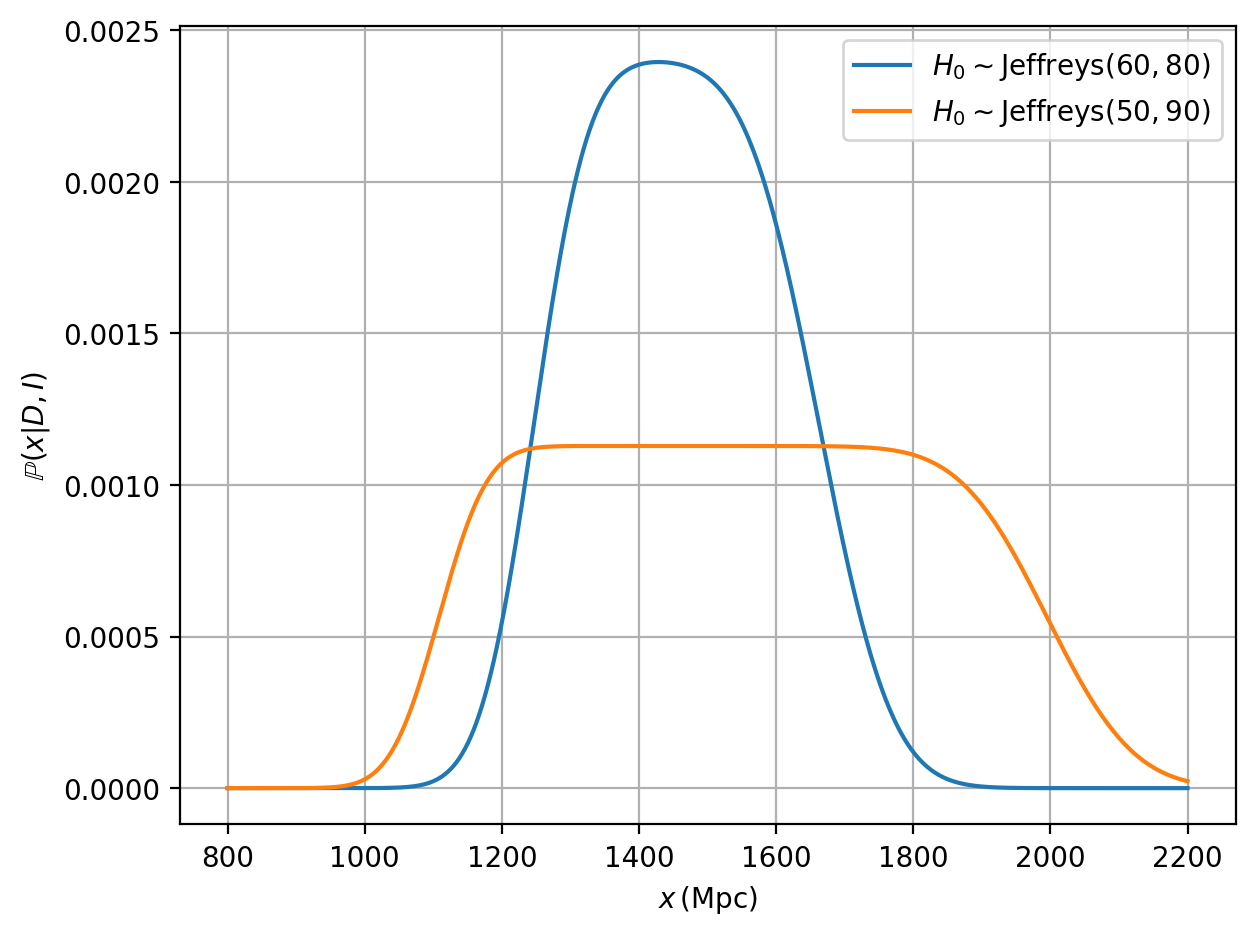

In [2]:
def probx(x, H0, vm, sigma):
    xx, hh = np.meshgrid(x, H0)
    H0prior = jeffreys_prior(hh, H0[0], H0[-1])
    like = gaussian(xx * hh, vm, sigma)
    # We set a uniform prior on x, which is redundant with the normalization in the end
    pst = np.trapz(like * H0prior, x=H0, axis=0)
    return normalize(pst, x)

n = 1000
xvec = np.linspace(800, 2200, n)
H0vec_lim1 = np.linspace(60, 80, n)
H0vec_lim2 = np.linspace(50, 90, n)
vm = 100 * 1000
sigma = 5 * 1000
probxvec_lim1 = probx(xvec, H0vec_lim1, vm, sigma)
probxvec_lim2 = probx(xvec, H0vec_lim2, vm, sigma)
fig, ax = plt.subplots()
label_txt = r'$H_0 \sim \text{Jeffreys}'
ax.plot(xvec, probxvec_lim1, label=label_txt + r'({0:.0f},{1:.0f})$'.format(H0vec_lim1[0], H0vec_lim1[-1]))
ax.plot(xvec, probxvec_lim2, label=label_txt + r'({0:.0f},{1:.0f})$'.format(H0vec_lim2[0], H0vec_lim2[-1]))
ax.grid()
ax.legend()
ax.set_xlabel(r'$x \, \text{(Mpc)}$')
ax.set_ylabel(r'$\mathbb{P}(x|D,I)$')
fig.tight_layout()
plt.show()

Consistentemente com o que se espera, a posteriori $\mathbb{P}(x|D,I)$ é mais informativa quando a priori é mais restritiva.

## Questão 2

### a)

Quando o dado não é enviesado, a verossimilhança em $y$ é dada por

\begin{align*}
\mathbb{P}(y) &= \sum_{\theta_i \in \Omega(\theta)} \mathbb{P}(y | \theta = \theta_i, I) \mathbb{P}(\theta = \theta_i | I)\\
&= \mathbb{P}(y | \theta = 1/6, I)\\
& \sim \text{Binom}(y, 1/6)
\end{align*}

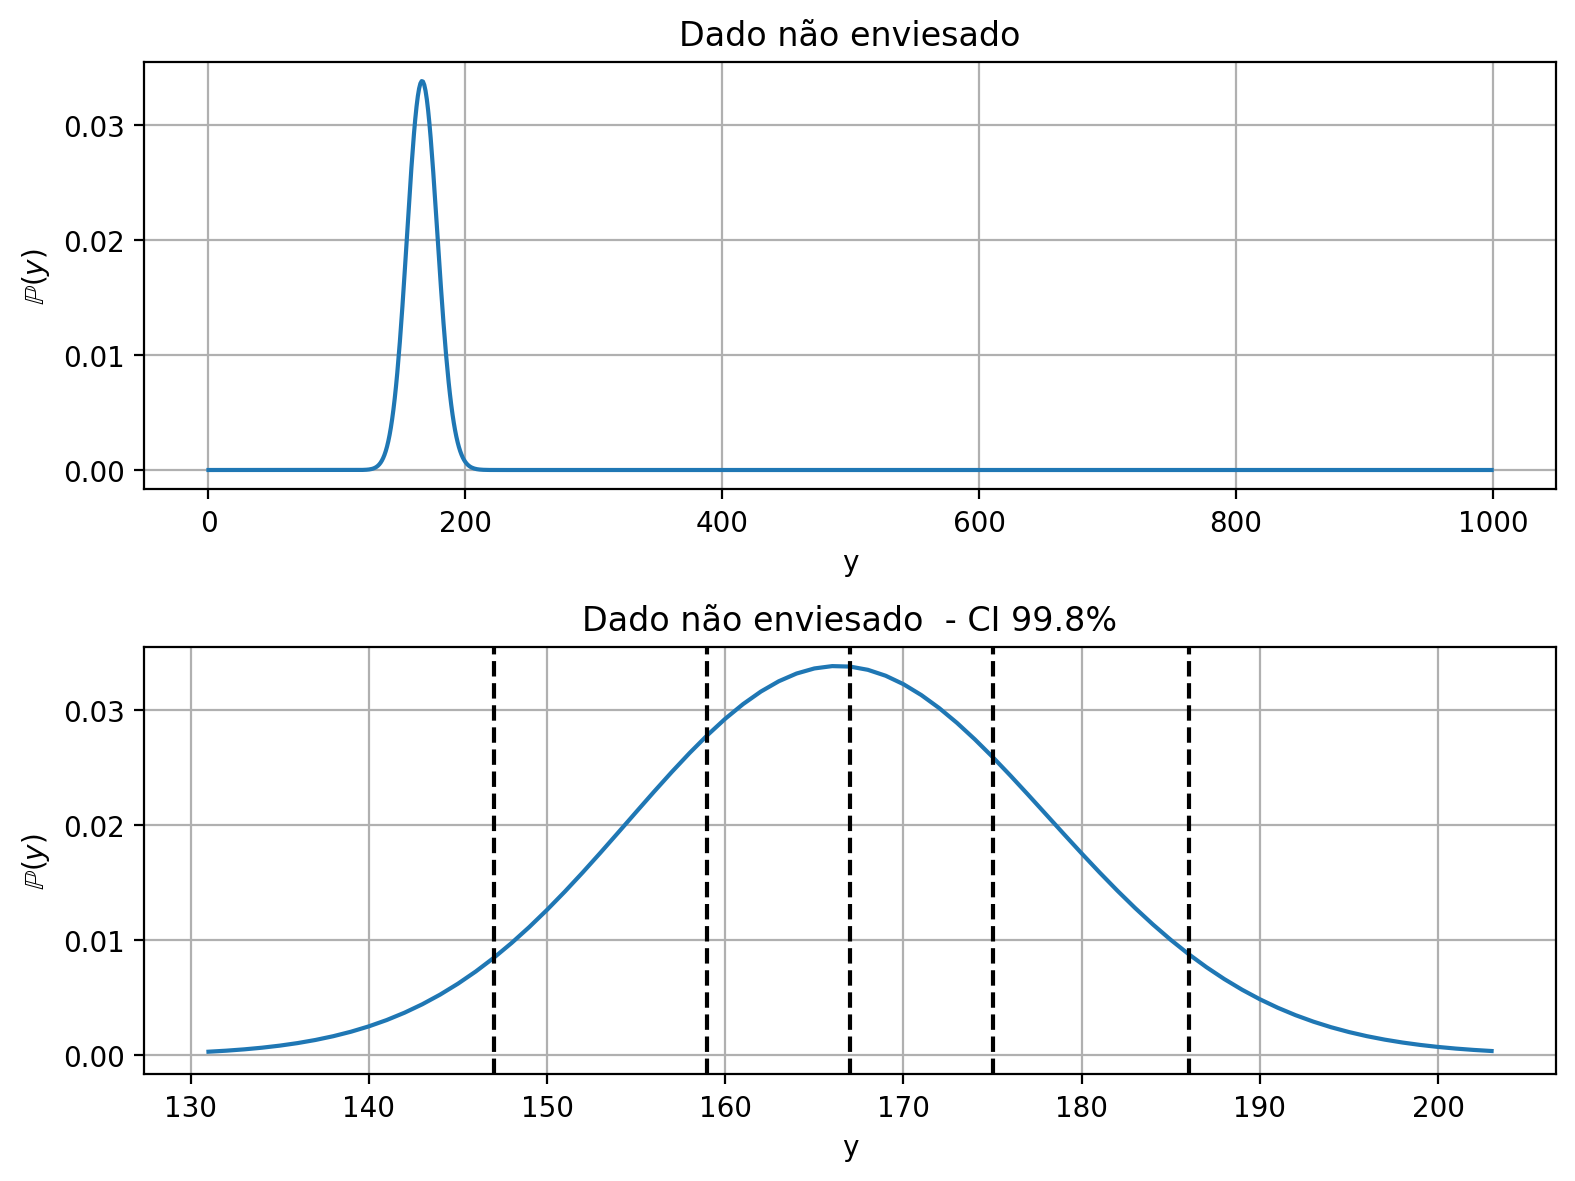

In [3]:
n = 1000
p = 1 / 6
y = np.arange(n)
zoomed_y = np.arange(binom.ppf(0.001, n, p), binom.ppf(0.999, n, p))

# Quantiles
qs = [0.05, 0.25, 0.50, 0.75, 0.95]
quantiles = quantile(binom.pmf(y, n, p), y, qs, discrete=True)

fig, axs = plt.subplots(2, 1, sharey=True, figsize=(8, 6))
axs[0].plot(y, binom.pmf(y, n, p))
axs[1].plot(zoomed_y, binom.pmf(zoomed_y, n, p))
for q in quantiles:
    axs[1].axvline(q, ls='--', c='k')

for ax in axs:
    ax.grid()
    ax.set_xlabel('y')
    ax.set_ylabel(r'$\mathbb{P}(y)$')
axs[0].set_title('Dado não enviesado')
axs[1].set_title('Dado não enviesado  - CI 99.8%')
fig.tight_layout()
plt.show()

In [4]:
theo_quantiles = binom.ppf(qs, n, p)
# Compare quantile computation with theoretical given by scipy.stats.binom.ppf
assert all(abs(quantiles - theo_quantiles) < 1e-3)

for pq, q in zip(qs, quantiles):
    display(Math(r'\mathbb{P}(y \leq q) = ' + r'{0} \Rightarrow q = {1:.2f}'.format(pq, q)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### b)

\begin{align*}
\mathbb{P}(y) &= \sum_{\theta_i \in \Omega(\theta)} \mathbb{P}(y | \theta = \theta_i, I) \mathbb{P}(\theta = \theta_i | I)\\
&= \mathbb{P}(y | \theta = 1 / 12, I) \mathbb{P}(\theta = 1/ 12 | I) + \mathbb{P}(y | \theta = 1 / 6, I) \mathbb{P}(\theta = 1/ 6 | I) + \mathbb{P}(y | \theta = 1 / 4, I) \mathbb{P}(\theta = 1/ 4 | I)\\
&= 0.25\mathbb{P}(y | \theta = 1 / 12, I) + 0.5\mathbb{P}(y | \theta = 1 / 6, I) + 0.25\mathbb{P}(y | \theta = 1 / 4, I)
\end{align*}

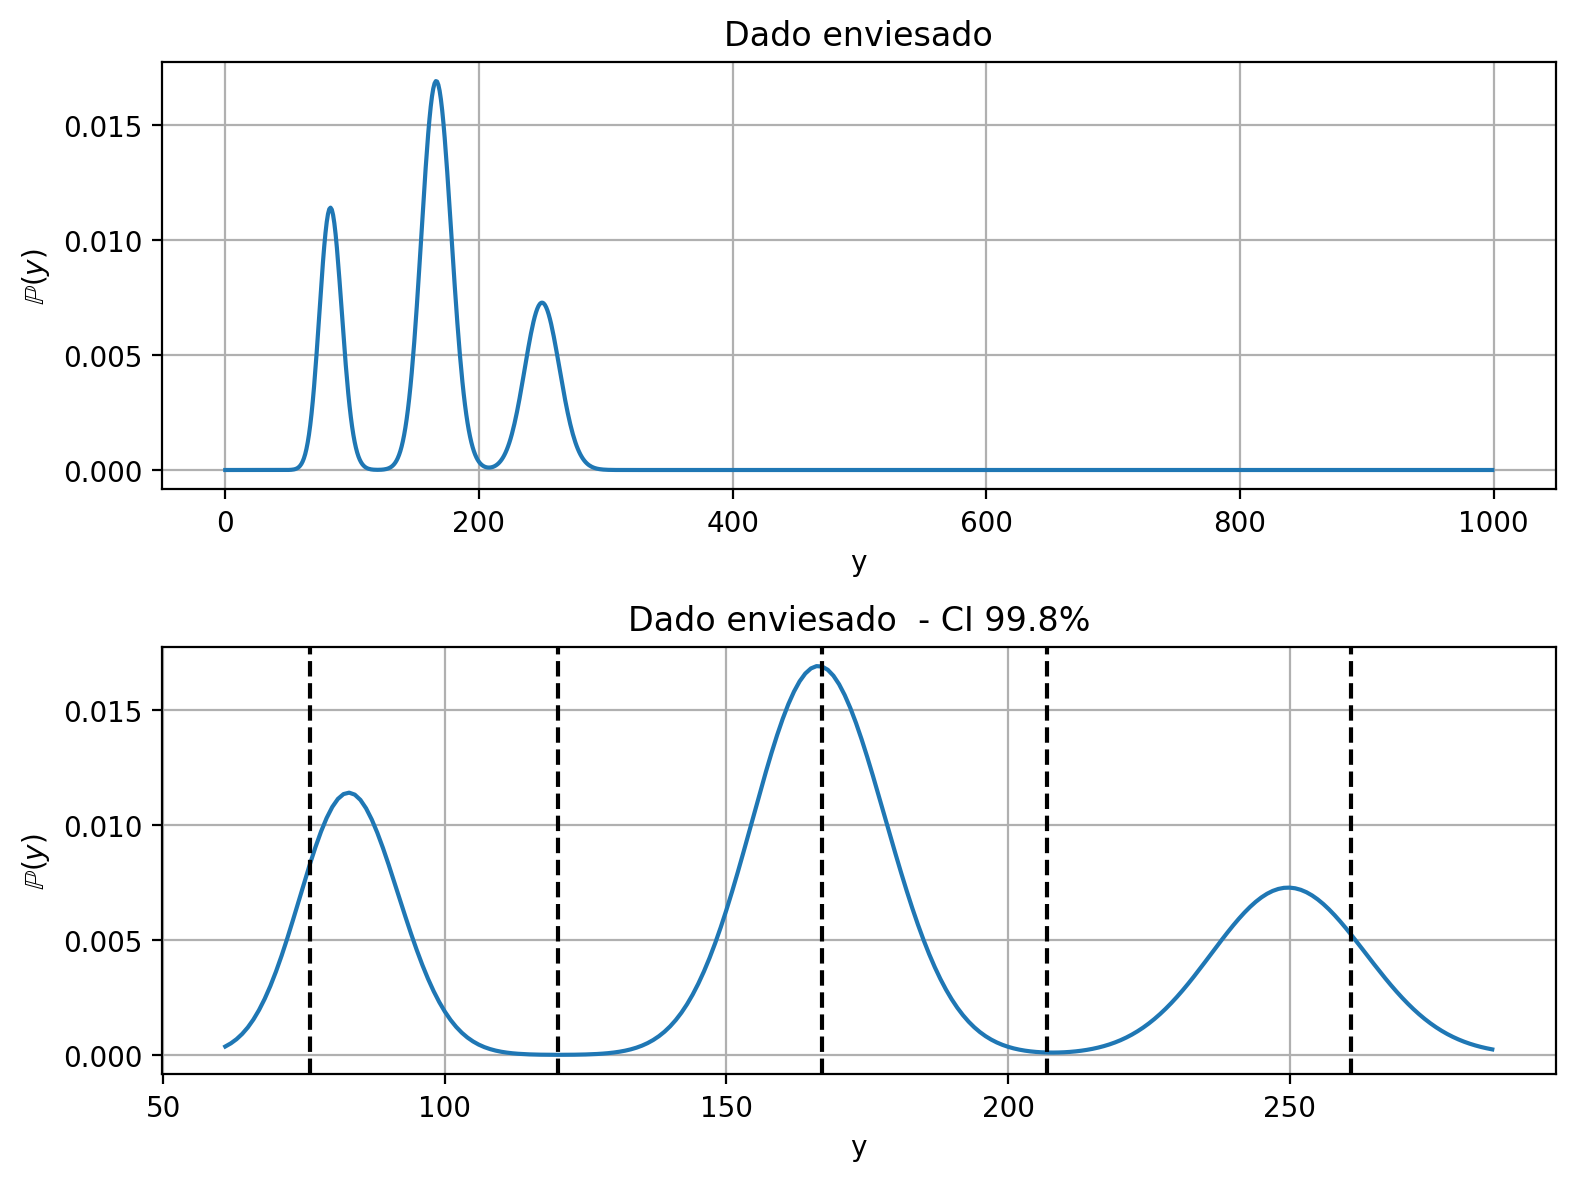

In [5]:
n = 1000
y = np.arange(n)
def pmf(k, n):
    return 0.25 * binom.pmf(k, n, 1 / 12) + 0.5 * binom.pmf(k, n, 1 / 6) + 0.25 * binom.pmf(k, n, 1 / 4)

qs = [0.05, 0.25, 0.50, 0.75, 0.95]
quantiles = quantile(pmf(y, n), y, qs, discrete=True)
ymin, ymax = quantile(pmf(y, n), y, [0.001, 0.999], discrete=True)
zoomed_y = np.arange(ymin, ymax)

fig, axs = plt.subplots(2, 1, sharey=True, figsize=(8, 6))
axs[0].plot(y, pmf(y, n))
axs[1].plot(zoomed_y, pmf(zoomed_y, n))
for q in quantiles:
    axs[1].axvline(q, ls='--', c='k')

for ax in axs:
    ax.grid()
    ax.set_xlabel('y')
    ax.set_ylabel(r'$\mathbb{P}(y)$')
axs[0].set_title('Dado enviesado')
axs[1].set_title('Dado enviesado  - CI 99.8%')
fig.tight_layout()
plt.show()

In [6]:
for pq, q in zip(qs, quantiles):
    display(Math(r'\mathbb{P}(y \leq q) = ' + r'{0} \Rightarrow q = {1:.2f}'.format(pq, q)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Questão 3

### a)

Seja $\theta_i$ o ângulo que o segmento $\overline{FP_i} = (x_i, 0) - (x_F, y_F)$ faz com a vertical $\overline{FH} = (x_F, 0)- (x_F, y_F)$. A relação geométrica entre esses pontos é dada por

$$ x_i = x_F + y_F \tan\theta_i $$

Quando $\theta_i = 0$, o pulso é detectado diretamente na frente do farol, $x_i = x_F$. Já os limites $x_i \to \pm \infty$ correspondem a $\theta_i \to \pm \pi/2$. A informação que tem-se sobre a direção dos pulsos é que $\theta_i \sim \mathcal{U}(-\pi/2, \pi/2)$. Portanto,

\begin{align*}
\mathbb{P}(X_i \leq x | x_F, y_F) &= \mathbb{P}(x_F + y_F \tan\theta_i \leq x | x_F, y_F)\\
&= \mathbb{P}\left(\theta_i \leq \arctan \left[\frac{x - x_F}{y_F}\right] \Bigg| x_F, y_F \right)\\
&= \frac{1}{\pi} \arctan \left[\frac{x - x_F}{y_F}\right]
\end{align*}

A p.d.f $p(x)$ é dada por

\begin{align*}
p(x) &= \frac{d}{dx}\mathbb{P}(X_i \leq x | x_F, y_F) \\
&= \frac{1}{\pi}  \frac{d}{dx} \arctan \left[\frac{x - x_F}{y_F}\right]\\
&= \frac{1}{\pi} \frac{y_F}{y_F^2 + (x - x_F)^2},
\end{align*}

que corresponde a uma curva Lorentzianna.

### b)

Pelo teorema de Bayes,

\begin{align*}
\mathbb{P}(x_F | \{x_i\}, y_F) & \propto \prod_i \mathbb{P}(x_i | x_F, y_F) \mathbb{P}(x_F | y_F)\\
&\propto \prod_i \frac{1}{1 + (x_i - x_F)^2},
\end{align*}

onde a última relação é válida ao se escolher uma priori uniforme para $x_F$.

Na célula abaixo, calculamos a posteriori de $x_F$ para diferentes datasets e indicamos as suas respectivas medianas assim como o HDI a $1 \sigma$:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

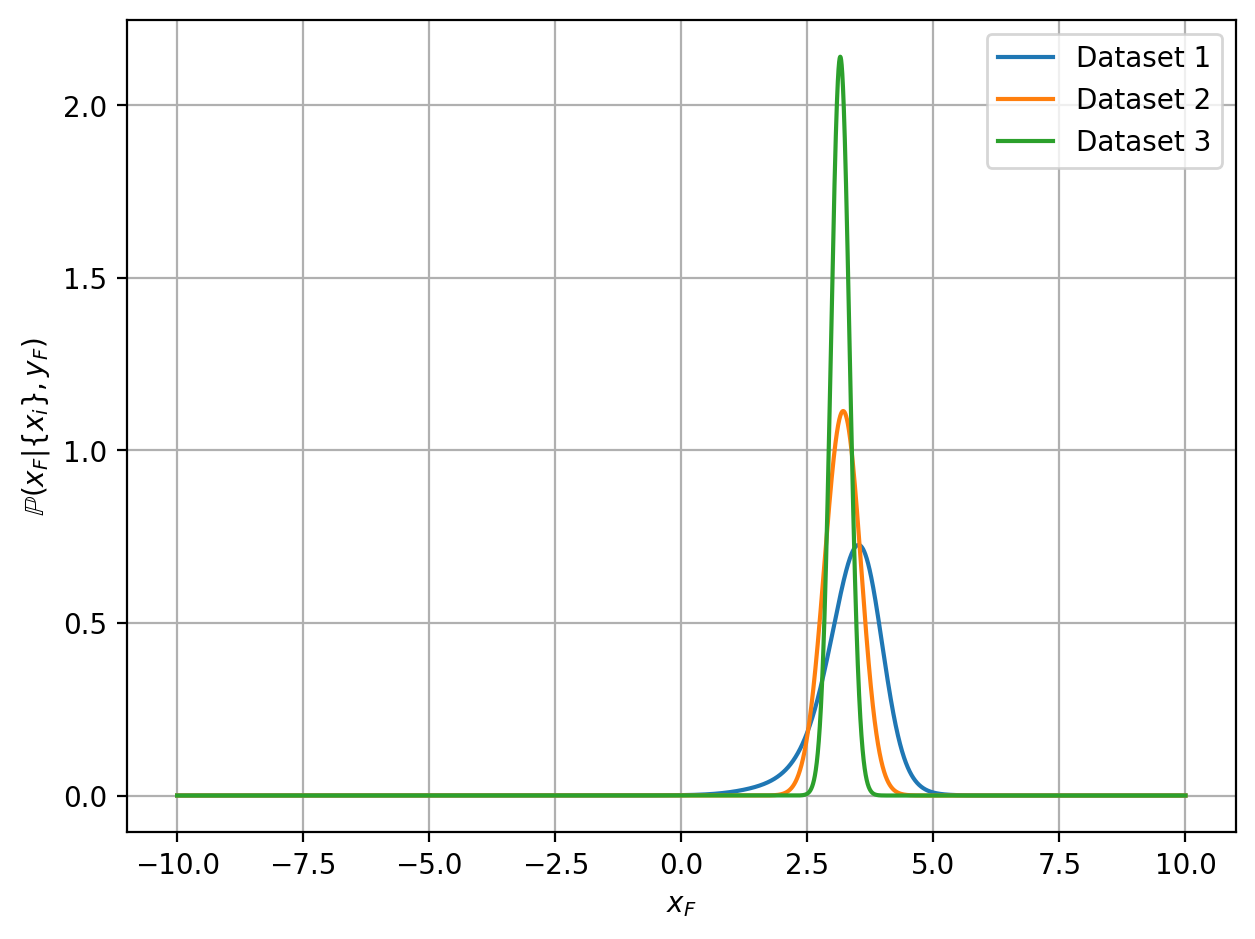

In [7]:
def loglike(xi, xf, yf):
    return - np.log(yf ** 2 + (xi - xf) ** 2)

def logprob(dataset, xf, yf, prior=1.):
    return np.sum([loglike(xi, xf, yf) for xi in dataset], axis=0) + np.log(prior)

def prob(dataset, xf, yf, **kwargs):
    return normalize(safe_exp(logprob(dataset, xf, yf, **kwargs)), xf)

nx = 10000
yf = 1
xf = np.linspace(-10, 10, nx)

# Getting datasets
ndatasets = 3
dts = [np.loadtxt(f'../data/pb2/q3ds{i + 1}.txt') for i in range(ndatasets)]

fig, ax = plt.subplots()
for i, ds in enumerate(dts):
    pdf = prob(ds, xf, yf)
    ax.plot(xf, prob(ds, xf, yf), label=f'Dataset {i + 1}')
    imedian, ilow, ihigh = hdi(pdf, xf, 0.68)
    median, low, high = xf[imedian], xf[ilow], xf[ihigh]
    txt = r'x_F = ' + r'{0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}'.format(median, median - low, high - median)
    display(Math(r'\text{Dataset }' + f'{i+1} :' + txt))

ax.legend()
ax.grid()
ax.set_xlabel(r'$x_F$')
ax.set_ylabel(r'$\mathbb{P}(x_F | \{x_i \}, y_F)$')

fig.tight_layout()
plt.show()

Observa-se que a escolha do intervalo da priori uniforme foi bem conservadora. Com efeito, a região de confiança a $4\sigma$ pra o primeiro dataset, que apresenta o menor poder vinculante, está dentro do intervalo $(0, 5.66)$, conforme ilustra a célula abaixo.

In [8]:
pdf = prob(dts[0], xf, yf)
imedian, ilow, ihigh = hdi(pdf, xf, 0.9999)
median, low, high = xf[imedian], xf[ilow], xf[ihigh]
txt = r'\mathbb{P}(' + r'{0:.2f} < x_F <{1:.2f} | D_1, y_F, I) = 0.9999'.format(low, high)
display(Math(txt))

<IPython.core.display.Math object>

 Com isso em mente, podemos refazer o cálculo usando uma priori mais restritiva $x_F \sim \mathcal{U}(0,6)$. Dessa vez, sombreamos a região de confiança a $1\sigma$ para cada caso.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

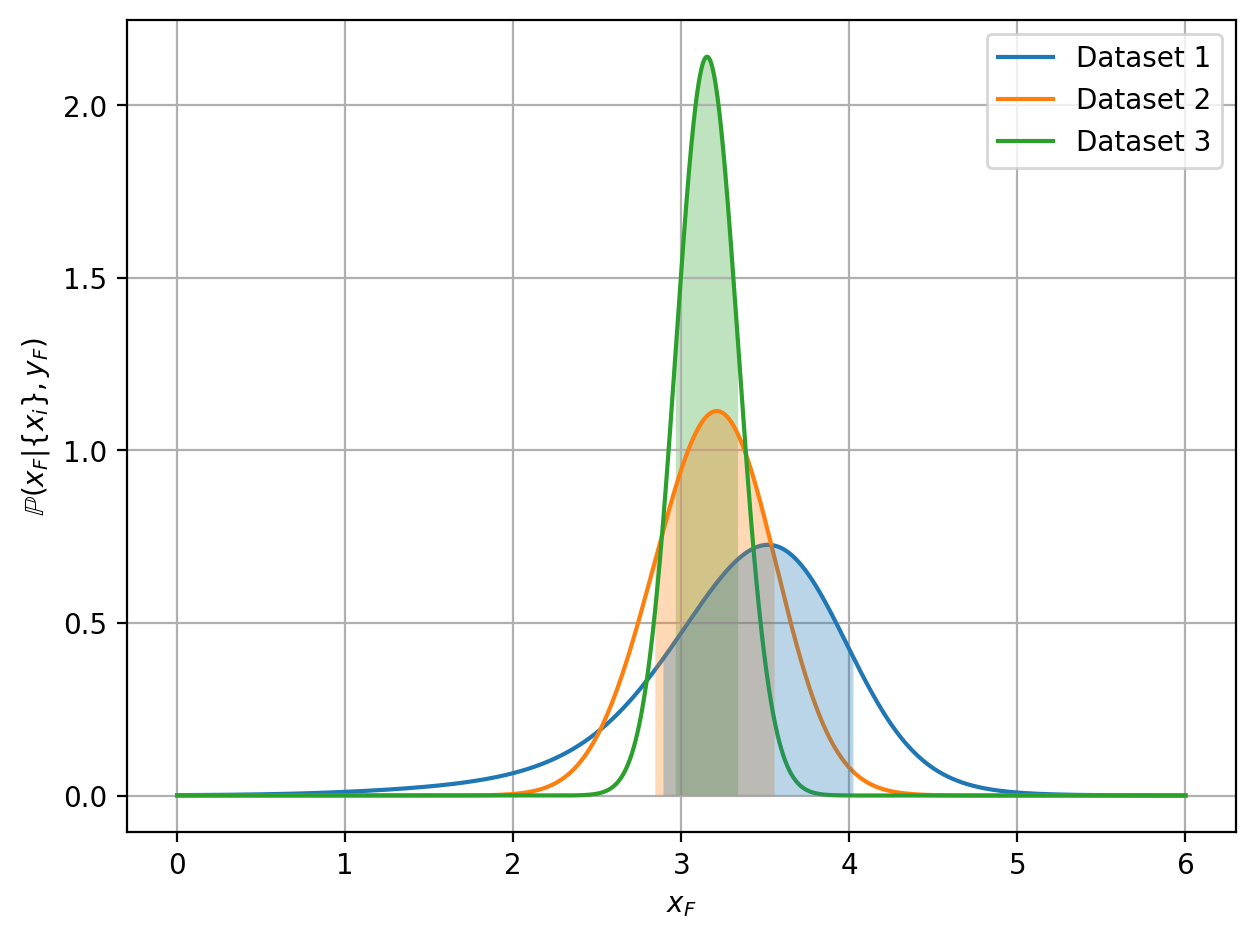

In [9]:
xf = np.linspace(0, 6, nx)
fig, ax = plt.subplots()
for i, ds in enumerate(dts):
    pdf = prob(ds, xf, yf)
    ax.plot(xf, prob(ds, xf, yf), label=f'Dataset {i + 1}')
    imedian, ilow, ihigh = hdi(pdf, xf, 0.68)
    median, low, high = xf[imedian], xf[ilow], xf[ihigh]
    ax.fill_between(xf[ilow:ihigh], 0, pdf[ilow:ihigh], alpha=0.3, zorder=3-i)
    txt = r'x_F = ' + r'{0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}'.format(median, median - low, high - median)
    display(Math(r'\text{Dataset }' + f'{i+1} :' + txt))

ax.legend()
ax.grid()
ax.set_xlabel(r'$x_F$')
ax.set_ylabel(r'$\mathbb{P}(x_F | \{x_i \}, y_F)$')

fig.tight_layout()
plt.show()

O terceiro dataset, que congrega o maior número de dados, tem o maior  poder vinculante sobre a posição do farol $x_F$. Os três conjuntos de dados resultam em valores para $x_F$ que são consistentes a $1\sigma$.  Observa-se também que a mudança para um intervalo mais restritivo não modifica o intervalo de confiança para $x_F$, o que advém da escolha de uma priori uniforme.

## Questão 4

Seja $n$ o número total de bactérias na amostra e $k$ destas o número de bactérias do tipo A. Podemos modelar $\mathbb{P}(k|n,p,I)$ como uma distribuição binomial de parâmetro desconhecido $p$: $\mathbb{P}(\text{bactéria é do tipo A}) = p$. Seja $(k_1, n_1)$ o conjunto de dados da amostra 1, e $(k_2, n_2)$ o conjunto de dados da amostra 2. Escrevemos

\begin{align*}
\mathbb{P}(k_2 | n_2, k_1, n_1, I) &= \int_0^1 \mathbb{P}(k_2, p | n_2, k_1, n_1, I) dp\\
&= \int_0^1 \mathbb{P}(k_2 | p, n_2, k_1, n_1, I)\mathbb{P}(p | n_2, k_1, n_1, I) dp\\
&= \int_0^1 \mathbb{P}(k_2 | p, n_2, I)\mathbb{P}(p | k_1, n_1, I) dp,
\end{align*}

onde a última igualdade se deve à hipótese de que as duas amostras são independentes. O resultado que encontramos é consistente com a abordagem bayesiana: a priori em $p$ para a segunda amostra é a distribuição posteriori de $p$ dado os resultados da primeira amostra. 

Desenvolvemos o segundo termo do integrando com o Teorema de Bayes,

\begin{align*}
\mathbb{P}(k_2 | n_2, k_1, n_1, I) &= \int_0^1 \mathbb{P}(k_2 | p, n_2, I)\frac{\mathbb{P}(k_1 | p, n_1, I) \mathbb{P}(p | n_1, I)}{\mathbb{P}(k_1 | n_1, I)} dp\\
&= \mathcal{N}^{-1} \int_0^1 \mathbb{P}(k_2 | p, n_2, I)\mathbb{P}(k_1 | p, n_1, I) \mathbb{P}(p | I)
\end{align*}

onde 

$$\mathcal{N} = \mathbb{P}(k_1 | n_1, I) =\int_0^1 \mathbb{P}(k_1 | p, n_1, I) \mathbb{P}(p | I) dp.$$

Escolhemos uma priori uniforme para $p$: $\mathbb{P} (p | I) = p$.

### 4.7)

In [10]:
n = 1000
pvec = np.linspace(0, 1, n)

def pbacteria(k2, n2, k1, n1):
    norm = np.trapz(binom.pmf(k1, n1, pvec), pvec)
    prob = binom.pmf(k2, n2, pvec) * binom.pmf(k1, n1, pvec)
    return np.trapz(prob, pvec) / norm

k2 = 6
n2 = 12
k1 = 3
n1 = 10
prob = pbacteria(k2, n2, k1, n1)
txt = f'(k_2 = {k2} | n_2 = {n2}, k_1 = {k1}, n_1 = {n1}, I) = {prob:.4f}'
display(Math(r'\mathbb{P}' + txt))

<IPython.core.display.Math object>

### 4.9)

In [11]:
def pbacteriacdf(k2max, n2, k1, n1):
    return np.sum([pbacteria(k2, n2, k1, n1) for k2 in range(k2max)])

k2max = 3
prob = 1.0 - pbacteriacdf(k2max, n2, k1, n1)
txt = f'(k_2 \geq {k2max} | n_2 = {n2}, k_1 = {k1}, n_1 = {n1}, I) = {prob:.4f}'
display(Math(r'\mathbb{P}' + txt))

<IPython.core.display.Math object>

## Questão 5

Calculamos a p.d.f da média $\overline{X} = n^{-1}\sum_{i=1}^n X_i$ de duas maneiras:

1) Amostrando $x_i^j \sim \mathcal{B}(\alpha, \beta)$ e montando um histograma da média amostral

Usamos uma técnica simples de *inversion sampling*, em que $N \times n \gg 1$ variáveis $U_i \sim \mathcal{U}(0, 1)$ são tiradas. Se $F(x_i) \equiv  \mathbb{P}(X \leq x_i)$ é a cdf de $X \sim \mathcal{B}(\alpha, \beta) $, é possível demonstrar então que $F^{-1}(U_i) \sim \mathcal{B}(\alpha, \beta)$:

\begin{align*}
\mathbb{P}(F^{-1}(U_i) \leq x_i) &= \mathbb{P}(U_i \leq F(x_i))\\
&=F(x_i)\\
&=\mathbb{P}(X \leq x_i)
\end{align*}

A primeira igualdade vem do fato de $F$ ser uma função monotônica, enquanto que a segunda igualdade vem da cdf de uma varíavel aleatória uniforme em $[0,1]$. Esse algoritmo pode implementado de maneira eficiente pois a inversão de $F$ na prática consiste em uma busca binária. 

Em seguida, calcula-se a média amostral

$$ \overline{x}^j = \frac{1}{n}\sum_{i=1}^n x_i^j,$$

para $j \in 1, \ldots, N$. Finalmente, aproximamos a pdf $p_{\overline{X}}$ com um histograma (normalizado) das amostras $\overline{x}^j$, já que essas são independentes.


2) Usando o teorema da convolução: calculando numericamente a FFT de $\mathcal{B}(\alpha, \beta)$, e depois a FFT inversa de $\mathcal{F}[\mathcal{B}(\alpha, \beta)]^n$

Como as variáveis são independentes, a pdf da sua soma é dada pela convolução das suas pdfs, que é mais facilmente calculada usando a transformada de Fourier:

$$p_{\overline{X}_n} \propto \mathcal{F}^{-1}[\mathcal{F}[p_X]^n]$$

A implementação dessa técnica é direta, porém é preciso se atentar a alguns detalhes. Ao calcular a transformada de Fourier discreta (DFT) do vetor de $p_X$, deve-se concatenar um número de zeros ao final deste (*zero-padding*). A quantidade de zeros depende de $n$: o tamanho total do vetor modificado de $p_X$ deve ser $n \, \text{len}(p_X) -n+1$, que é o tamanho do vetor resultante da DFT inversa após $n - 1$ auto-convoluções. Esse método está implementado na função `utils.math.fftconvolution`.

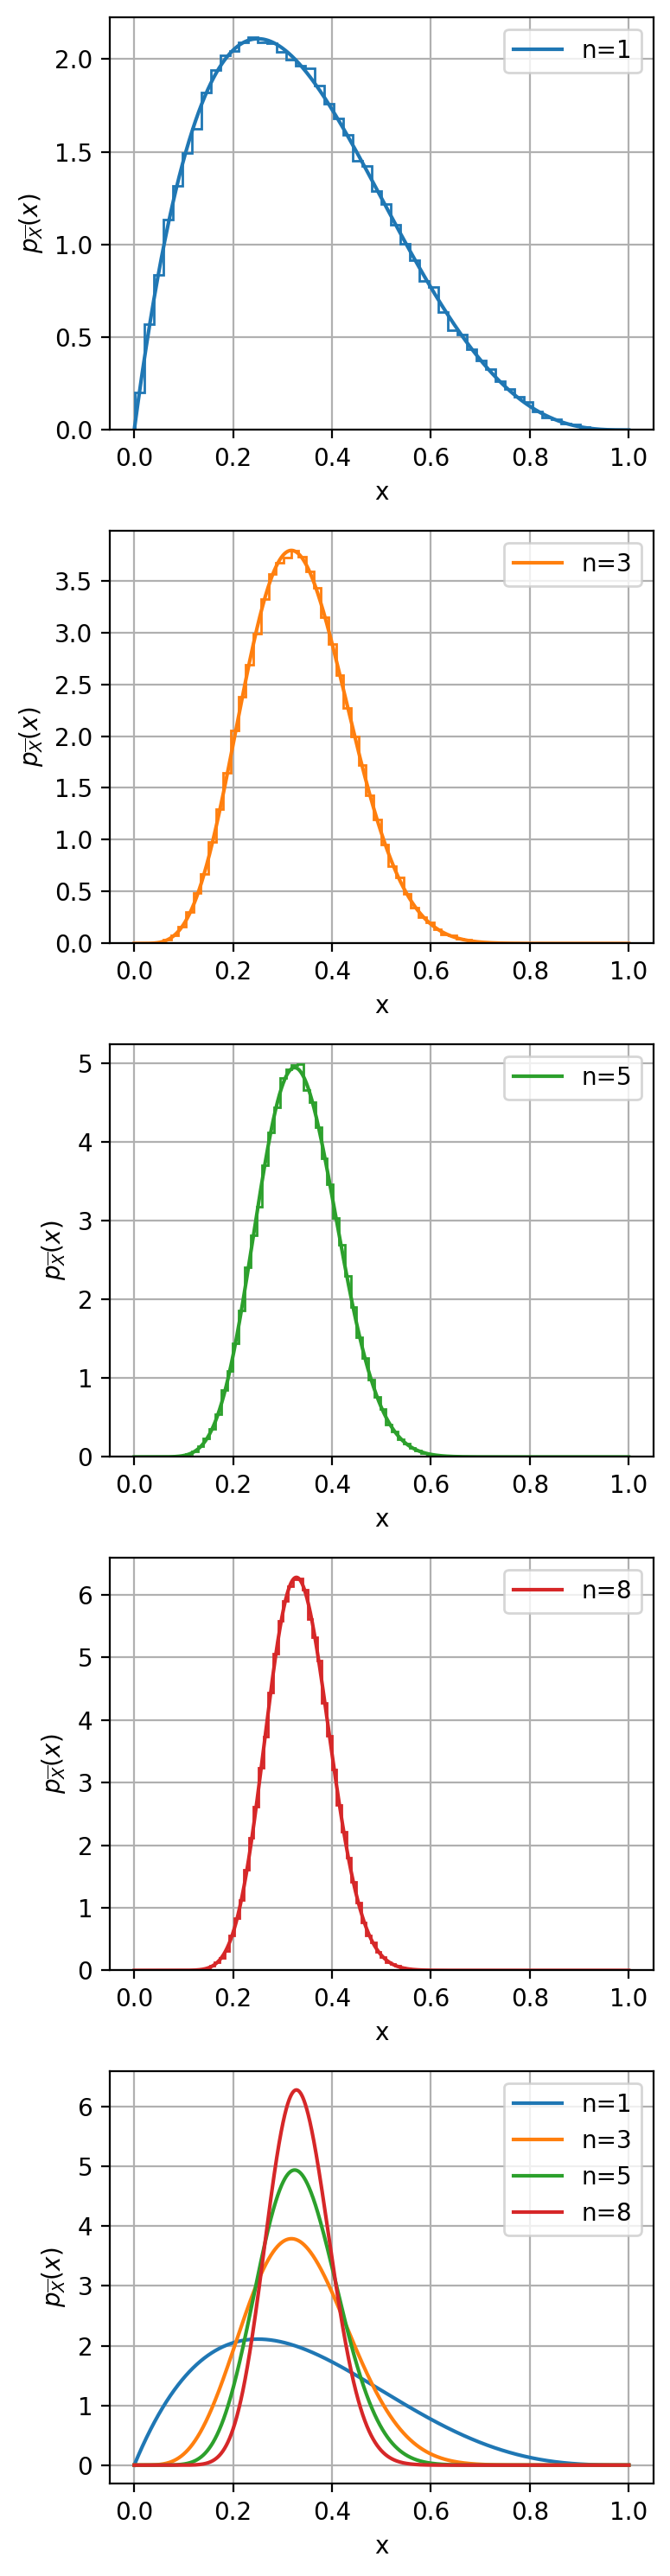

In [12]:
def average_pdf_inversion_sampling(n, alpha, beta, x, nsamples):
    pdf = beta_pdf(x, alpha, beta)
    samples = inversion_sampling(pdf, x, n * nsamples).reshape((n, nsamples))
    return np.mean(samples, axis=0)

nvec = [1, 3, 5, 8]
ncurves = len(nvec)
nfig = ncurves + 1
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
alpha, beta = 2, 4
nsamples = 100000
nbins = 50
ns = 10000
x = np.linspace(0, 1, ns)
pdf = beta_pdf(x, alpha, beta)
fig, axs = plt.subplots(nfig, 1, figsize=(4, 3 * nfig))
convolved_pdfs = np.empty((ncurves, ns))
pdf_samples = np.empty((ncurves, nsamples))
for i, (n, c, ax) in enumerate(zip(nvec, colors, axs)):
    pdf_samples[i, :] = average_pdf_inversion_sampling(n, alpha, beta, x, nsamples)
    ax.hist(pdf_samples[i, :], nbins, density=True, histtype='step', color=c)
    unnorm_convolved_pdf = fftconvolution(pdf, n)
    convolved_pdfs[i, :] = normalize(unnorm_convolved_pdf, x)
    ax.plot(x, convolved_pdfs[i, :], color=c, label=f'n={n}')
    axs[-1].plot(x, convolved_pdfs[i, :], color=c, label=f'n={n}')
    ax.grid()
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel(r'$p_{\overline{X}}(x)$')
    # ax.set_title(f'n={n}')

axs[-1].grid()
axs[-1].legend()
axs[-1].set_xlabel('x')
axs[-1].set_ylabel(r'$p_{\overline{X}}(x)$')

fig.tight_layout()
plt.show()

Observa-se qualitativamente a ação do Teorema do Limite Central: a medida que $n$ aumenta, as curvas parecem convergir para uma distribuição com uma determinada média, e com uma variância progressivamente menor.

In [13]:
sample_moments = np.empty((ncurves, 2))
fftconvolved_moments = np.empty((ncurves, 2))
for i, n in enumerate(nvec):
    sample_moments[i, 0] = np.mean(pdf_samples[i, :])
    sample_moments[i, 1] = np.var(pdf_samples[i, :], ddof=1)
    fftconvolved_moments[i, 0] = moment(convolved_pdfs[i, :], x, 1)
    fftconvolved_moments[i, 1] = moment(convolved_pdfs[i, :], x, 2, central=True)
    print(f'n={n} (sampling): mean = {sample_moments[i, 0]:.4f}, variance = {sample_moments[i, 1]:.4f}')
    print(f'n={n} (fft): mean = {fftconvolved_moments[i, 0]:.4f}, variance = {fftconvolved_moments[i, 1]:.4f}')


n=1 (sampling): mean = 0.3333, variance = 0.0318
n=1 (fft): mean = 0.3333, variance = 0.0317
n=3 (sampling): mean = 0.3331, variance = 0.0106
n=3 (fft): mean = 0.3333, variance = 0.0106
n=5 (sampling): mean = 0.3335, variance = 0.0063
n=5 (fft): mean = 0.3333, variance = 0.0063
n=8 (sampling): mean = 0.3332, variance = 0.0040
n=8 (fft): mean = 0.3333, variance = 0.0040


Enquanto a média amostral apresenta flutuações em $n$, a média obtida pelo cálculo numérico de

$$ \mathbb{E}(\overline{X}_n) = n^{-1}\mathbb{E}\left(\sum_{i=1}^n X_i \right) = n^{-1} \sum_{i=1}^n \mathbb{E}(X_i) =  \mathbb{E}(X_1) $$

é independente de $n$. A variância, no entanto, obedece 

$$ \text{Var}(\overline{X}_n) = n^{-2}\text{Var}\left(\sum_{i=1}^n X_i \right) = n^{-2} \sum_{i=1}^n \text{Var}(X_i) =  n^{-1}\text{Var}(X_1) $$
o que corresponde ao resultado observado:

In [14]:
for i, n in enumerate(nvec):
    print(f'n={n} (sampling): n * variance = {n * sample_moments[i, 1]:.4f}')
    print(f'n={n} (fft): n * variance = {n * fftconvolved_moments[i, 1]:.4f}')

n=1 (sampling): n * variance = 0.0318
n=1 (fft): n * variance = 0.0317
n=3 (sampling): n * variance = 0.0318
n=3 (fft): n * variance = 0.0317
n=5 (sampling): n * variance = 0.0317
n=5 (fft): n * variance = 0.0317
n=8 (sampling): n * variance = 0.0318
n=8 (fft): n * variance = 0.0317


Na célula abaixo, comparamos, para diferentes valores de $n$, as pdfs $p_{\overline{X}_n}$ com as respectivas distribuições normais que têm a mesma média e variância. Espera-se que a concordância aumente quanto maior o valor de $n$ pelo Teorema do Limite Central.

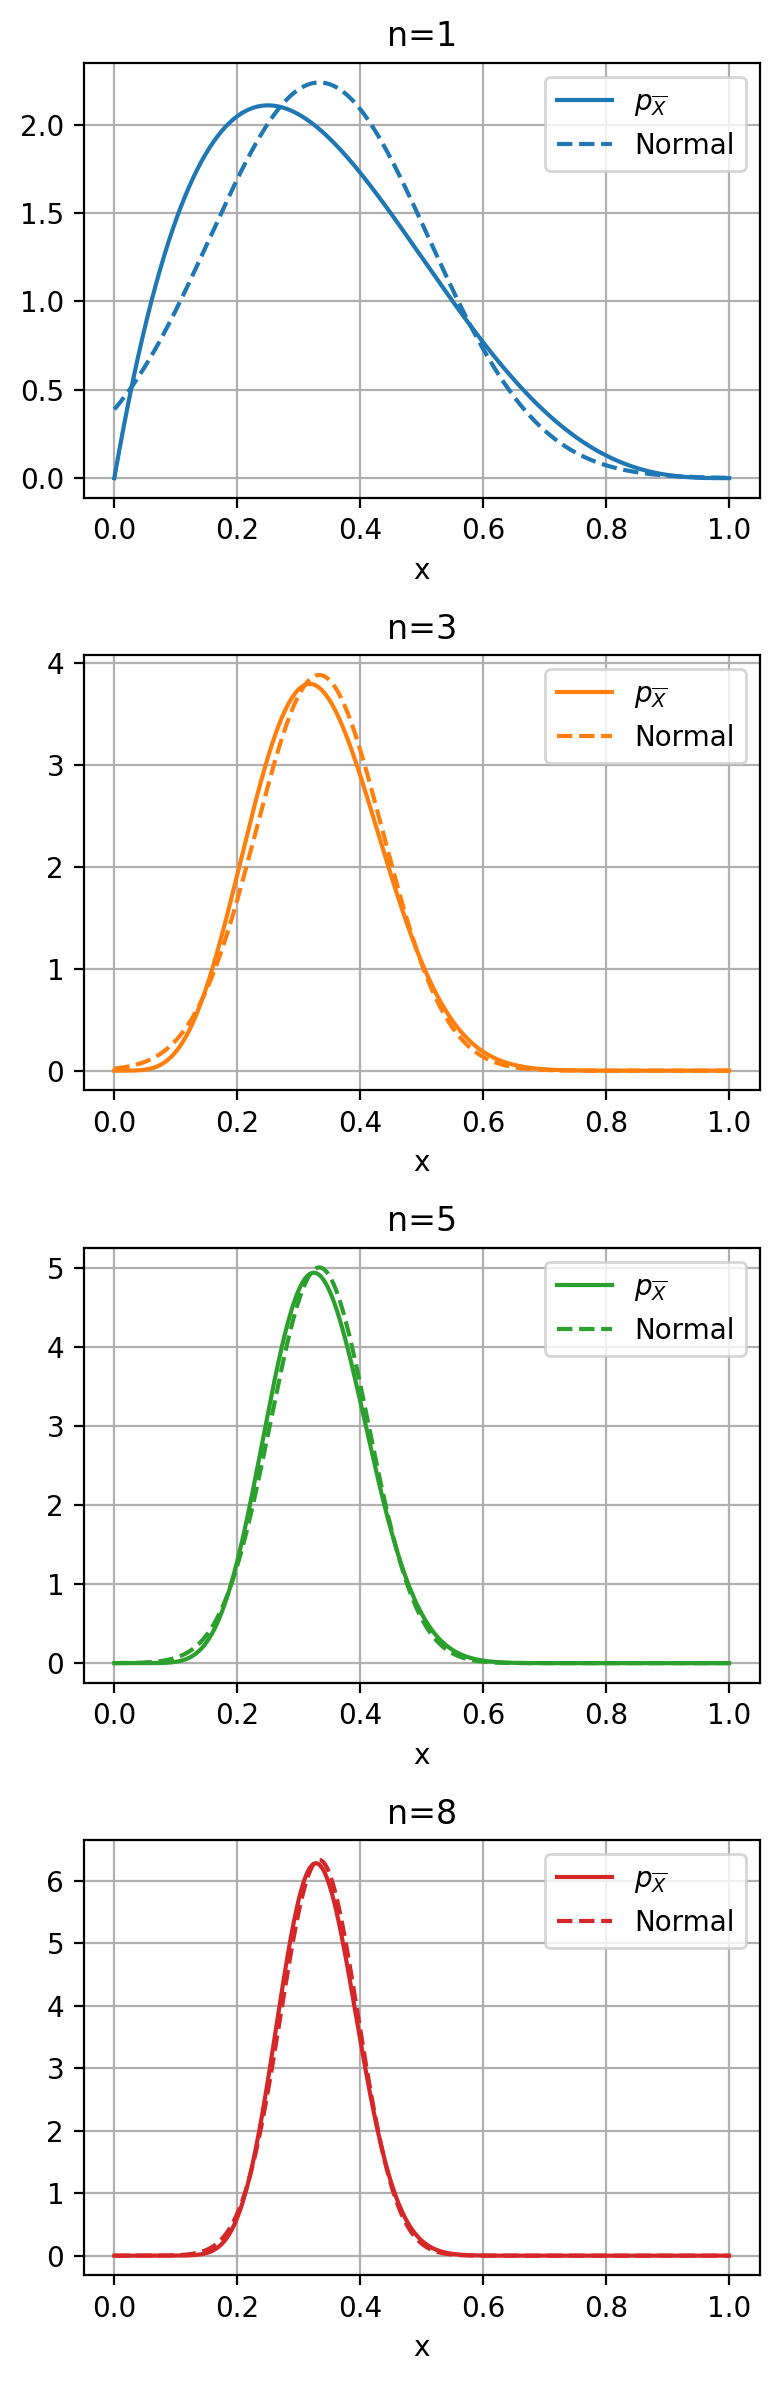

In [15]:
fig, axs = plt.subplots(ncurves, 1, figsize=(4, 3 * ncurves))
for i, (n, ax, c) in enumerate(zip(nvec, axs, colors)):
    mu = fftconvolved_moments[i, 0]
    sigma = np.sqrt(fftconvolved_moments[i, 1])
    normdist = gaussian(x, mu, sigma)
    ax.plot(x, convolved_pdfs[i, :], label=r'$p_{\overline{X}}$', color=c)
    ax.plot(x, normdist, label='Normal', color=c, ls='--')
    ax.legend()
    ax.grid()
    ax.set_xlabel('x')
    ax.set_title(f'n={n}')

fig.tight_layout()
plt.show()

## Questão 6

### a)

Sabemos que

\begin{align*}
p_{obs} &= FPR (1-p_{true}) +(1 - FNR)p_{true}\\
&= (1 - FPR - FNR)p_{true} + FPR
\end{align*}

é a probabilidade de um teste retornar positivo. Como $p_{true} \in (0,1)$, conclui-se que $FPR < p_{obs} < 1 - FNR$. Com efeito, a prevalência observada agrega tanto os falsos positivos como as verdadeiras incidências da doença, portanto é de se esperar que $p_{obs}$ seja maior do que $FPR$. Similarmente, os falsos negativos diminuem a prevalência observada, limitando o valor máximo que ela poderia obter.

 Invertemos a relação acima para encontrar $p_{true}(p_{obs})$:

$$ p_{true} = (1 - FPR - FNR)^{-1} (p_{obs} - FPR) $$

Ao probabilidade de $n_{yes}$ testes retornarem positivos em um total $n_{tot}$ segue uma distribuição binomial de parâmetro $p_{obs}$,

$$\mathbb{P}(n_{yes} | n_{tot}, p_{obs}) = \binom{n_{tot}}{n_{yes}} p_{obs}^{n_{yes}}(1 - p_{obs})^{n_{tot} - n_{yes}} $$

Usamos o teorema de Bayes para relacionar a probabilidade $p_{obs}$:

$$
\mathbb{P}(p_{obs} |n_{yes}, n_{tot}) = \mathcal{N}^{-1} \mathbb{P}(n_{yes} | n_{tot}, p_{obs}) \mathbb{P}(p_{obs} | n_{tot}),
$$

onde 

$$\mathcal{N} = \int_{FPR}^{1-FNR} \mathbb{P}(n_{yes} | n_{tot}, p_{obs}) {P}(p_{obs} | n_{tot}) dp_{obs}$$

Ao escolher uma priori uniforme $\mathbb{P}(p_{obs} | n_{tot})$ no intervalo $(FPR, 1 - FNR)$, encontramos

$$
\mathbb{P}(p_{obs} |n_{yes}, n_{tot}) \propto p_{obs}^{n_{yes}}(1 - p_{obs})^{n_{tot} - n_{yes}}.
$$

Observamos que $p_{obs}$ segue a mesma forma funcional de uma distribuição beta $\mathcal{B}(n_{yes} + 1, n_{tot} - n_{yes} + 1)$. No entanto, as duas distribuições não estão definidas no mesmo domínio, já que $p_{obs} \in (FPR, 1 - FNR)$. Para calcular a probabilidade $\mathbb{P}(p_{true} | n_{yes}, n_{tot})$, fazemos o seguinte desenvolvimento:

\begin{align*}
\mathbb{P}(p_{true} \leq p | n_{yes}, n_{tot}) &= \mathbb{P}(p_{true}(p_{obs}) \leq p | n_{yes}, n_{tot})\\
&= \mathbb{P}((1 - FPR - FNR)^{-1} (p_{obs} - FPR) \leq p | n_{yes}, n_{tot})\\
&= \mathbb{P}(p_{obs} \leq p(1 - FPR - FNR) + FPR | n_{yes}, n_{tot})\\
&\propto \int_{FPR}^{p(1 - FPR - FNR) + FPR} p_{obs}^{n_{yes}}(1 - p_{obs})^{n_{tot} - n_{yes}} dp_{obs}\\
&\propto \int_{0}^{p} (p_{true} + p_{min})^{n_{yes}}[(1 - FNR - FPR)^{-1} - p_{true} - p_{min}]^{n_{tot} - n_{yes}} dp_{true},
\end{align*}

onde definimos $p_{min} = (1 - FPR - FNR)^{-1} FPR$.

### b)

Na célula abaixo, verificamos numericamente que a p.d.f de $p_{true}$ pode ser aproximada por uma distribuição beta deslocada 
$$\mathcal{B}[\alpha = n_{yes} + 1, \beta = n_{tot}(1 - FNR - FPR) - n_{yes} +1](p_{true} + p_{min})$$

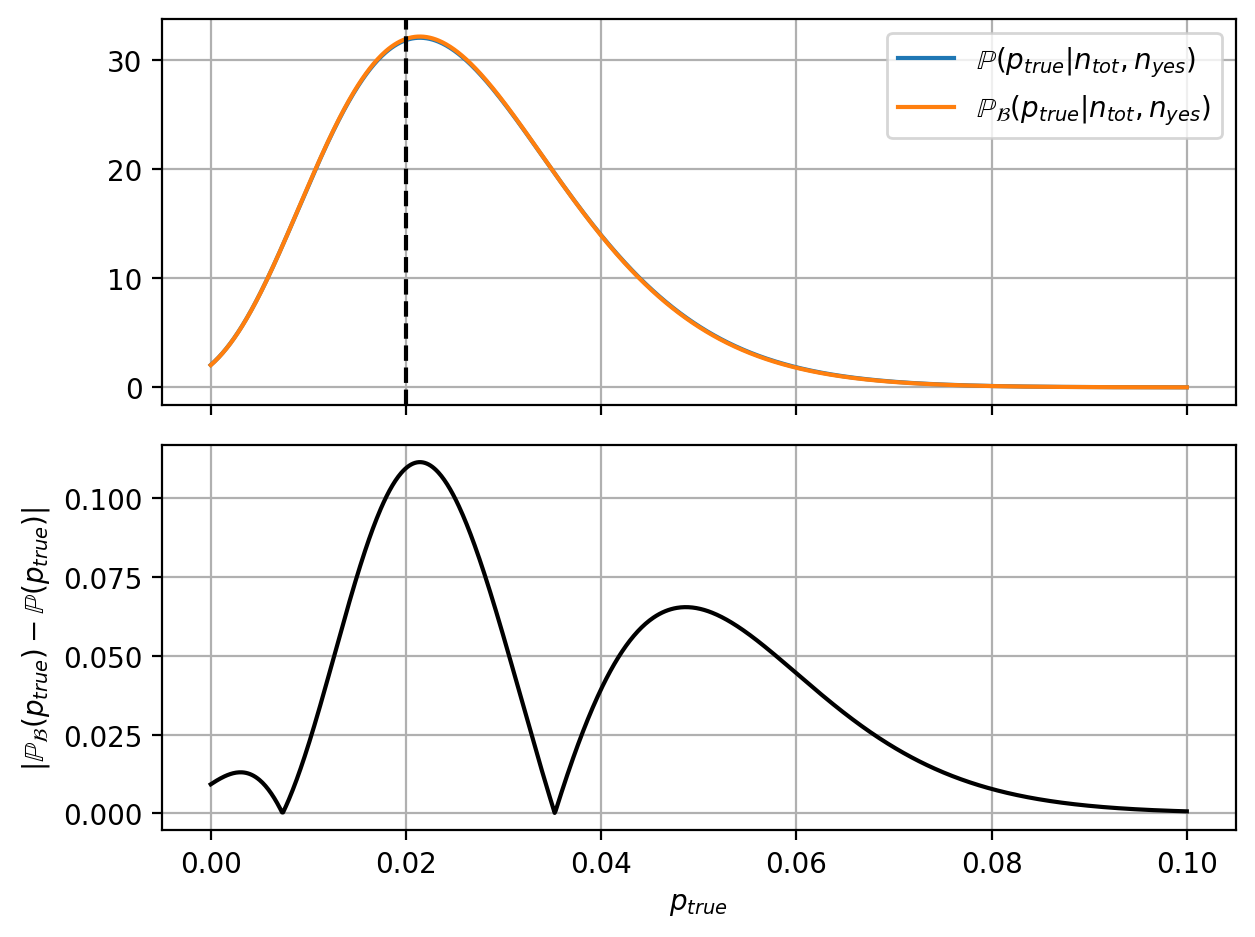

In [16]:
from scipy.stats import beta as betadist
n= 1000
x = np.linspace(0, 0.1, n)

def ptrue_exactdist(x, nyes, ntot, fpr, fnr):
    scale = 1 - fpr - fnr
    pmin = fpr / (1 - fpr - fnr)
    ptrue_pdf = (x + pmin) ** nyes * (1 / scale - x - pmin) ** (ntot - nyes)
    return normalize(ptrue_pdf, x)

def ptrue_approxdist(x, nyes, ntot, fpr, fnr):
    pmin = fpr / (1 - fpr - fnr)
    alpha = nyes + 1
    beta_approx = ntot * (1 - fpr - fnr) - nyes + 1
    return normalize(betadist.pdf(x + pmin, alpha, beta_approx), x)
    #return normalize(betadist.pdf(x, alpha, ntot - nyes + 1, loc=-pmin, scale=pmin/fpr),x)

# Parameters
ntot = 250
nyes = 7
fpr = 0.01
fnr = 0.15

fig, axs = plt.subplots(2, 1, sharex=True)
ax1, ax2 = axs.flatten()
ptrue_exact = ptrue_exactdist(x, nyes, ntot, fpr, fnr)
ptrue_approx = ptrue_approxdist(x, nyes, ntot, fpr, fnr)
residuals = np.abs(ptrue_approx - ptrue_exact)
ax1.plot(x, ptrue_exact, label=r'$\mathbb{P}(p_{true} | n_{tot}, n_{yes})$')
ax1.plot(x, ptrue_approx, label=r'$\mathbb{P}_{\mathcal{B}}(p_{true} | n_{tot}, n_{yes})$')
ax2.plot(x, residuals, color='k')
ax1.axvline(-fpr / (1 - fnr - fpr) + (nyes + 1) / (ntot + 1), ls='--', color='k')

ax2.set_xlabel(r'$p_{true}$')
ax2.set_ylabel(r'$|\mathbb{P}_{\mathcal{B}}(p_{true}) - \mathbb{P}(p_{true})|$')
ax1.legend()
ax1.grid()
ax2.grid()
fig.tight_layout()
plt.show()

Verificamos que os resíduos da aproximação são $\mathcal{O}(0.1)$ no domínio de $p_{true}$.

### c)

Na célula abaixo, testamos a aproximação da função beta para diferentes combinações de $(n_{yes}, n_{true}, FPR, FNR)$. Observamos que a aproximação é sensível ao parâmetro FNR, que pode assumir valores entre 0 e 1 (veja as curvas superior esquerda e inferior direita.) Em contrapartida, a taxa de falsos positivos é sempre inferior a $n_{yes} / n_{tot}$ (veja a curva inferior esquerda). A aproximação também perde validade ao aumentarmos a razão $n_{yes} / n_{tot}$, como ilustra a curva superior direita.

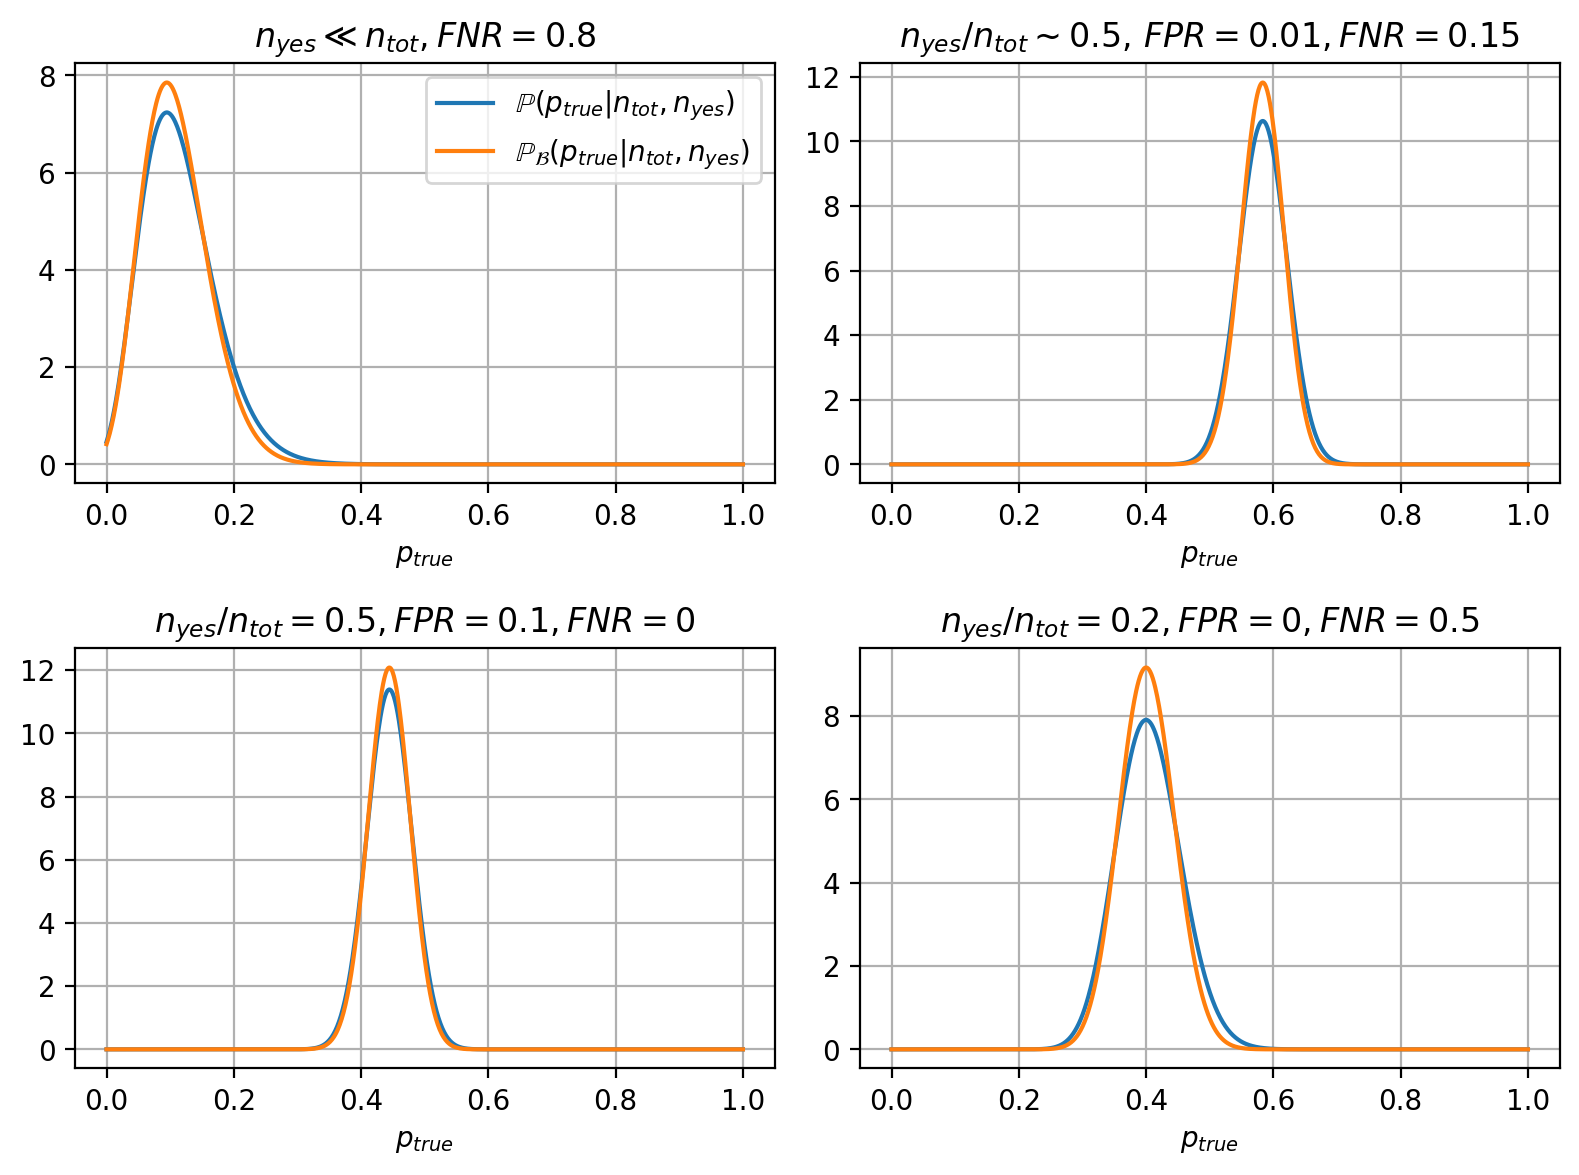

In [17]:
cases = {
    r'$n_{yes} \ll n_{tot}, FNR = 0.8$': (7, 250, 0.01, 0.8, 1),
    r'$n_{yes} / n_{tot} \sim 0.5, \, FPR = 0.01, FNR = 0.15$': (125, 250, 0.01, 0.15, 1),
    r'$n_{yes} / n_{tot} = 0.5, FPR=0.1, FNR=0$': (125, 250, 0.1, 0., 1),
    r'$n_{yes} / n_{tot} = 0.2, FPR=0, FNR=0.5$': (50, 250, 0., 0.5, 1)
}

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()
for i, (title, params) in enumerate(cases.items()):
    nyes, ntot, fpr, fnr, xmax = params
    x = np.linspace(0, xmax, n)
    ptrue_exact = ptrue_exactdist(x, nyes, ntot, fpr, fnr)
    ptrue_approx = ptrue_approxdist(x, nyes, ntot, fpr, fnr)
    axs[i].plot(x, ptrue_exact, label=r'$\mathbb{P}(p_{true} | n_{tot}, n_{yes})$')
    axs[i].plot(x, ptrue_approx, label=r'$\mathbb{P}_{\mathcal{B}}(p_{true} | n_{tot}, n_{yes})$')
    axs[i].set_title(title)
    axs[i].set_xlabel(r'$p_{true}$')
    axs[i].grid()

axs[0].legend()
fig.tight_layout()
plt.show()

### d)

Se considerarmos o teste realizado em $N$ cidades, teremos $N$ pares de dados $(n_{yes}, n_{tot})$. Se fizermos as hipóteses de que esses pares são independentes entre si e que todos amostram a verdadeira prevalência global $p_{true}$ do estado, podemos desenvolver

\begin{align*}
\mathbb{P}(p_{true} | \{ n^i_{yes} \}, \{ n^i_{tot} \}) &= \frac{\mathbb{P}(\{ n^i_{yes} \} |p_{true}, \{ n^i_{tot} \})}{\mathbb{P}(\{ n^i_{yes} \} | \{ n^i_{tot} \})}\mathbb{P}(p_{true})\\
&= \frac{ \prod_i \mathbb{P}(n^i_{yes}|p_{true}, n^i_{tot})}{\prod_i \mathbb{P}(n^i_{yes} | n^i_{tot})}\mathbb{P}(p_{true})\\
&= \prod_i \frac{\mathbb{P}(p_{true}|n^i_{yes}, n^i_{tot})\mathbb{P}(n^i_{yes} | n^i_{tot})}{\mathbb{P}(n^i_{yes} | n^i_{tot})\mathbb{P}(p_{true})}\mathbb{P}(p_{true})\\
&= \prod_i \frac{\mathbb{P}(p_{true}|n^i_{yes}, n^i_{tot})}{\mathbb{P}(p_{true})}\mathbb{P}(p_{true})\\
\end{align*}

Observamos que a distribuição posteriori resultante é a priori $\mathbb{P}(p_{true})$ vezes a razão posteriri-priori calculada para cidade.

Na célula abaixo, tomamos como exemplo $(n_{yes}, n_{tot}) = (7, 250)$ para a cidade 1 e $(n_{yes}, n_{tot}) = (5, 250)$ para a cidade 2.

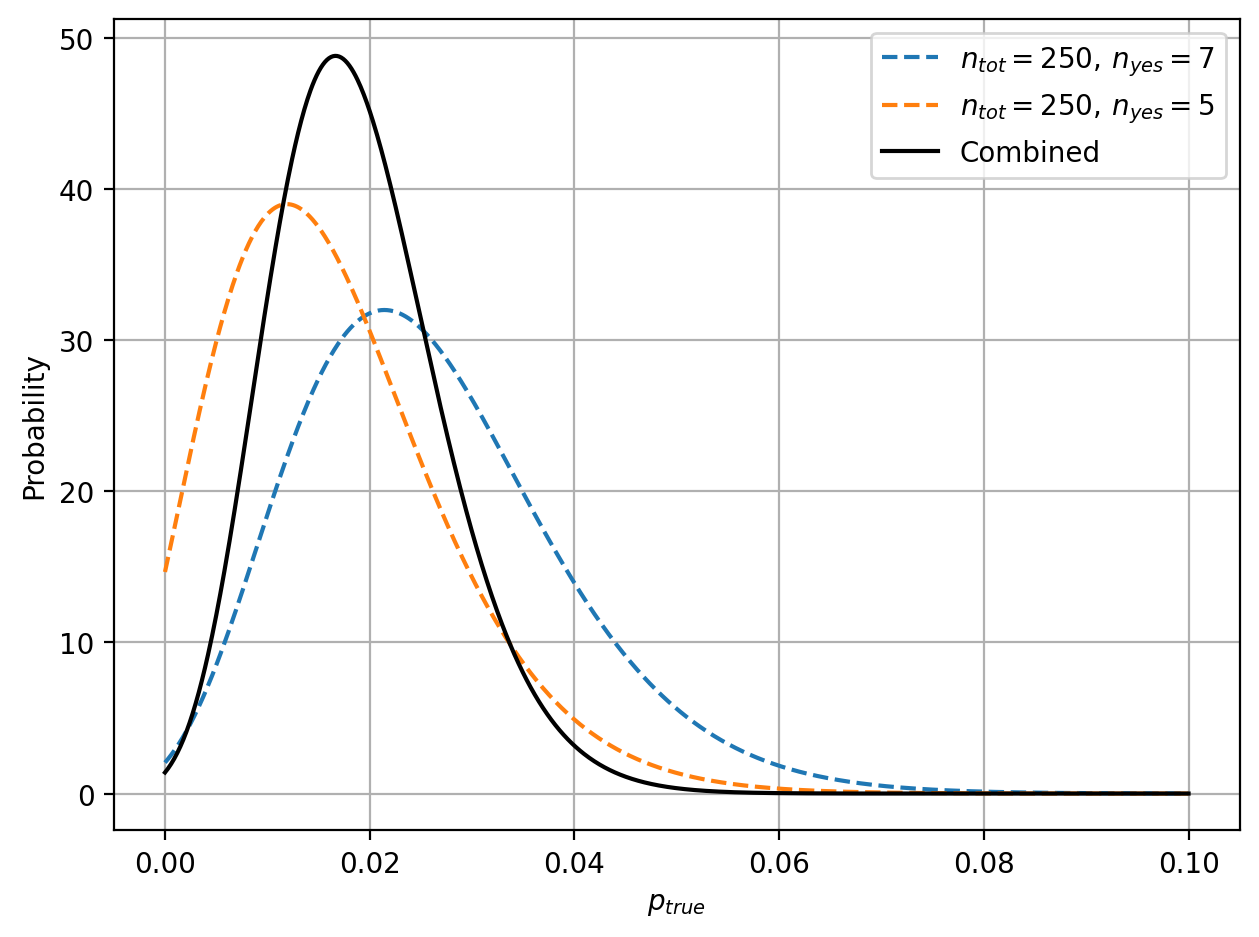

In [18]:
# Parameters
ntot1 = 250
nyes1 = 7
ntot2 = 250
nyes2 = 5
fpr = 0.01
fnr = 0.15

def plotlabel(nyes, ntot):
    return r'$n_{tot} = ' + f'{ntot}' + r',\,n_{yes} = ' + f'{nyes}$'

x = np.linspace(0, 0.1, n)
fig, ax = plt.subplots()
ptrue1_exact = ptrue_exactdist(x, nyes1, ntot1, fpr, fnr)
ptrue2_exact = ptrue_exactdist(x, nyes2, ntot2, fpr, fnr)
ptrue_exact = normalize(ptrue1_exact * ptrue2_exact, x)
ax.plot(x, ptrue1_exact, '--', label=plotlabel(nyes1, ntot1))
ax.plot(x, ptrue2_exact, '--', label=plotlabel(nyes2, ntot2))
ax.plot(x, ptrue_exact, color='k', label='Combined')

ax.set_xlabel(r'$p_{true}$')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()